In [1]:
import json
from functools import reduce
import os
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# midi data1 note numbers
# https://inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies

# type 9 = note (velocity 1-127 onset, 0 offset)
# type 11 = pedal (velocity 127 onset, 0 offset)

# velocity = 0 -> offset

In [3]:
current_folder = globals()['_dh'][0]

with open(os.path.join(current_folder, 'sabers_edge.json')) as f:
    data = json.load(f)

In [4]:
print("json contains the following initial keys")
for key, value in data.items():
    print(key)

print("time division:", data["timeDivision"])

def sum_delta_time(cur_sum, note):
    return cur_sum + int(note["deltaTime"])

track = data['track'][-1]['event']
sum_of_delta_time = reduce(sum_delta_time, track, 0)
print("sum of track -> deltaTime:", sum_of_delta_time)

json contains the following initial keys
formatType
tracks
track
timeDivision
time division: 384
sum of track -> deltaTime: 117913


In [5]:
data_for_df = [{"deltaTime": data["deltaTime"],
                "type": data["type"],
                "channel": data["channel"],
                "data1": data["data"][0],
                "data2": data["data"][1]}
               for data in track[:-1]]

In [6]:
my_df = pd.DataFrame(data_for_df)
my_df

,deltaTime,type,channel,data1,data2
0,2511,9,0,59,75
1,11,9,0,41,48
2,1,9,0,29,54
3,9,9,0,48,54
4,2,11,0,64,127
...,...,...,...,...,...
4503,0,9,0,66,0
4504,769,11,0,64,0
4505,19,9,0,79,0
4506,1,9,0,72,0


array([[<AxesSubplot:title={'center':'deltaTime'}>]], dtype=object)

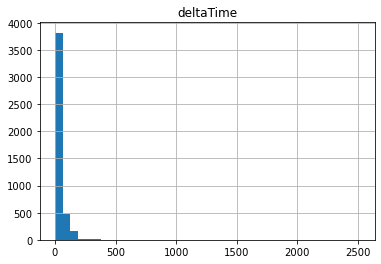

In [7]:
my_df.hist(column="deltaTime", bins=40)

array([[<AxesSubplot:title={'center':'type'}>]], dtype=object)

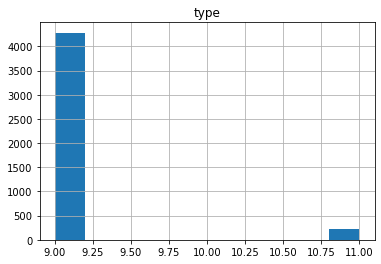

In [8]:
my_df.hist(column="type")

array([[<AxesSubplot:title={'center':'channel'}>]], dtype=object)

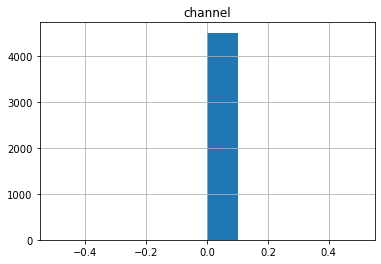

In [9]:
my_df.hist(column="channel")

array([[<AxesSubplot:title={'center':'data1'}>]], dtype=object)

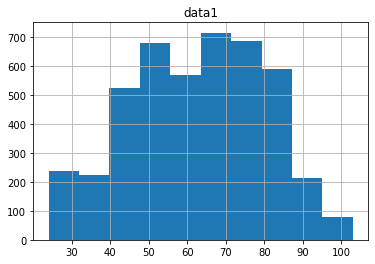

In [10]:
my_df.hist(column="data1")

array([[<AxesSubplot:title={'center':'data2'}>]], dtype=object)

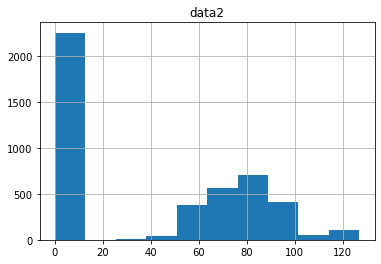

In [11]:
my_df.hist(column="data2")

In [12]:
(my_df['data2'] == 0).sum()

2254

In [13]:
(my_df['data2'] == 0)

0       False
1       False
2       False
3       False
4       False
        ...  
4503     True
4504     True
4505     True
4506     True
4507     True
Name: data2, Length: 4508, dtype: bool

In [16]:
my_df.loc[my_df['data2'] == 0]

,deltaTime,type,channel,data1,data2
7,113,9,0,48,0
8,0,9,0,55,0
10,4,9,0,50,0
13,134,9,0,29,0
14,0,9,0,41,0
...,...,...,...,...,...
4503,0,9,0,66,0
4504,769,11,0,64,0
4505,19,9,0,79,0
4506,1,9,0,72,0
